# Magnetized Spheres

This code calculates some magnetical problems with a spherical simetry.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import sphere
from fatiando.mesher import Sphere
from fatiando.vis import mpl
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
import mag_sphere_functions as mfun
% matplotlib inline

## Spheres

In [2]:
inc, dec = -60., 50. # inclination and declination of regional field
incs, decs = 70., -50.      # wrong direction or remanent

# creating the list of spheres
props1 = {'magnetization':utils.ang2vec(10., inc, dec)} # defining induced magnetization

model = [
    [17000, 22000, 3000, 1200,props1],
    [13000, 18000, 3000, 1200,props1]] # list of sphere models [x0,y0,z0,R,props]

# model for comparision with fatiando
model_fat = [
    Sphere(10000, 12000, 1000, 600,
          {'magnetization': utils.ang2vec(10., inc, dec)}),
    Sphere(10000, 20000, 1000, 600,
          {'magnetization': utils.ang2vec(10., inc, dec)})] # input fatiando

## Observation Points

In [3]:
#area over which the data are calculated
#x minimum, x maximum, y minimum and y maximum
area = [0, 30000, 5000, 35000] 

#number of data along the y and x directions
shape = (70,70)

#total number of data
N = shape[0]*shape[1]

#coordinates x and y of the data
x = np.linspace(area[0],area[1],shape[0]) # points in x
y = np.linspace(area[2],area[3],shape[0]) # points in y
xp,yp = np.meshgrid(x,y)    # creating mesh points
xp = xp.ravel()
yp = yp.ravel()

#vertical coordinates of the data
zp = -350. - 500.*utils.gaussian2d(xp, yp, 17000, 21000, 21000, 18500, angle=21)

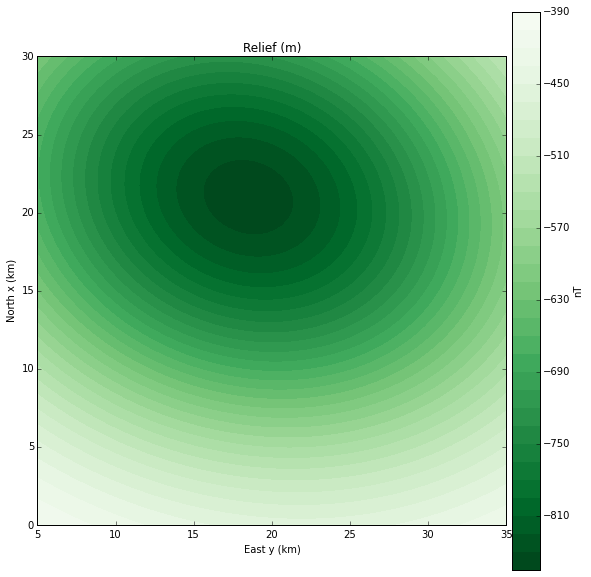

In [4]:
mpl.figure(figsize=(10,10))
mpl.title("Relief (m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, zp,shape,30, cmap=mpl.cm.Greens_r)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=1.0).set_label('nT')
mpl.m2km()
mpl.show()

### Result for magnetic induction of my function

In [5]:
Bx = mfun.bx_sphere(xp,yp,zp,model)
By = mfun.by_sphere(xp,yp,zp,model)
Bz = mfun.bz_sphere(xp,yp,zp,model)

### Result for total field anomaly of my function

In [6]:
tf = mfun.tf_sphere(xp,yp,zp,model,inc,dec)

### Ploting results

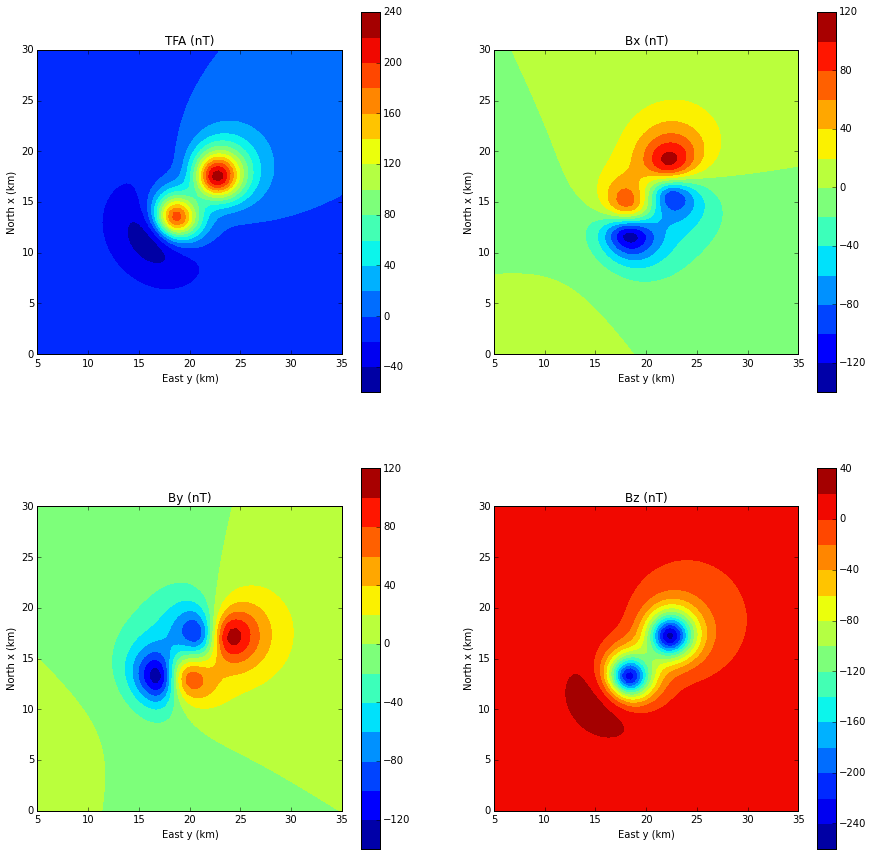

In [7]:
mpl.figure(figsize=(15,15))
mpl.axis('scaled')

mpl.subplot(2,2,1)
mpl.axis('scaled')
mpl.title("TFA (nT)")
mpl.contourf(yp, xp, tf,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(2,2,2)
mpl.axis('scaled')
mpl.title("Bx (nT)")
mpl.contourf(yp, xp, Bx,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(2,2,3)
mpl.axis('scaled')
mpl.title("By (nT)")
mpl.contourf(yp, xp, By,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(2,2,4)
mpl.axis('scaled')
mpl.title("Bz (nT)")
mpl.contourf(yp, xp, Bz,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()


mpl.show()

### Creating a layer with spheres

In [8]:
# creating a list of shperes below each observation points
model_layer = []
R = (3./(4.*np.pi))**(1./3)
h = np.zeros(N) - 100.                   # layer height
for i in range(len(xp)):
    model_layer.append([xp[i],yp[i],h,R,props1])


### Result for foward problem

In [9]:
A = mfun.sm_tf_sphere(xp, yp, zp, xp, yp, h ,inc,dec,inc,dec)

In [10]:
I = np.identity(xp.size)

In [11]:
f0 = np.trace(np.dot(A.T, A))/xp.size

In [12]:
u0 = 0.001

In [13]:
vp = np.linalg.solve(np.dot(A.T,A) + u0*f0*I,np.dot(A.T,tf))

In [14]:
model_layer = []
for xm, ym, hm, Rm, magm in zip(xp,yp,h,np.zeros(N)+R,vp):
    model_layer.append([xm, ym, hm, Rm, {'magnetization': utils.ang2vec(magm,inc,dec)}])

In [15]:
tf_layer_fd = np.dot(A,vp)

### Comparison with TFA function

In [16]:
np.allclose(tf,tf_layer_fd)

False

In [17]:
r = tf-tf_layer_fd

np.mean(r), np.std(r)

(0.15828918367066808, 0.18036995933905697)

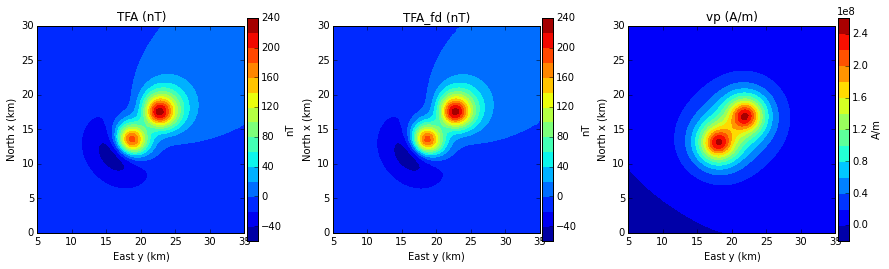

In [18]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("TFA (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, tf,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.subplot(1,3,2)
mpl.title("TFA_fd (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, tf_layer_fd,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.subplot(1,3,3)
mpl.title("vp (A/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, vp,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('A/m')
mpl.show()

In [19]:
A_bx = mfun.sm_bx_sphere(xp, yp, zp, xp, yp, h, inc, dec)

In [20]:
Bx_layer_fd = np.dot(A_bx,vp)

In [21]:
#Bx_layer = mfun.bx_sphere(xp, yp, zp, model_layer)

In [22]:
np.allclose(Bx,Bx_layer_fd)

False

In [23]:
A_by = mfun.sm_by_sphere(xp, yp, zp, xp, yp, h, inc, dec)

In [24]:
By_layer_fd = np.dot(A_by,vp)

In [25]:
#By_layer = mfun.by_sphere(xp, yp, zp, model_layer)

In [26]:
np.allclose(By,By_layer_fd)

False

In [27]:
A_bz = mfun.sm_bz_sphere(xp, yp, zp, xp, yp, h, inc, dec)

In [28]:
Bz_layer_fd = np.dot(A_bz,vp)

In [29]:
#Bz_layer = mfun.bz_sphere(xp, yp, zp, model_layer)

In [30]:
np.allclose(Bz,Bz_layer_fd)

False

In [31]:
A.shape

(4900L, 4900L)

In [32]:
H = np.dot(np.vstack([A, A_bx, A_by, A_bz]).T, np.vstack([A, A_bx, A_by, A_bz]))
h = np.dot(np.vstack([A, A_bx, A_by, A_bz]).T, np.hstack([tf, Bx, By, Bz]))

In [33]:
np.hstack([tf, Bx, By, Bz]).shape

(19600L,)

In [34]:
vp_joint = np.linalg.solve(H,h)

In [35]:
Bx_layer_fd_joint = np.dot(A_bx, vp_joint)
By_layer_fd_joint = np.dot(A_by, vp_joint)
Bz_layer_fd_joint = np.dot(A_bz, vp_joint)
tf_layer_fd_joint = np.dot(A, vp_joint)

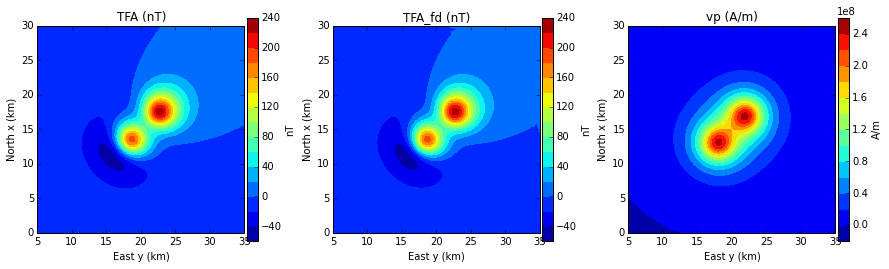

In [36]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("TFA (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, tf,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.subplot(1,3,2)
mpl.title("TFA_fd (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, tf_layer_fd_joint,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.subplot(1,3,3)
mpl.title("vp (A/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, vp_joint,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('A/m')
mpl.show()

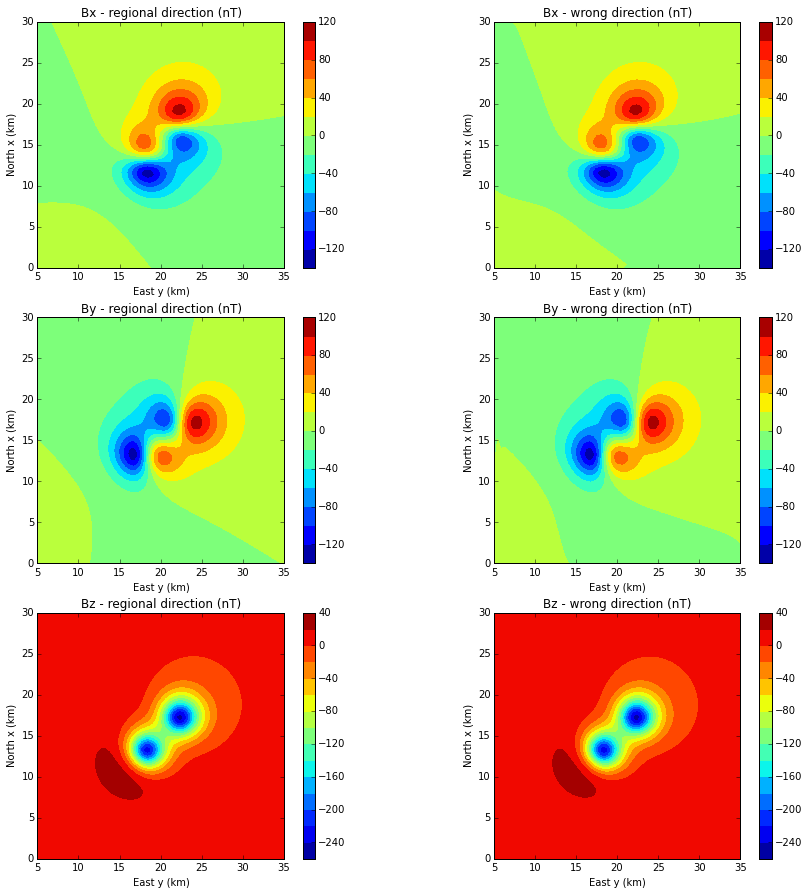

In [37]:
mpl.figure(figsize=(15,15))
mpl.axis('scaled')

mpl.subplot(3,2,1)
mpl.axis('scaled')
mpl.title("Bx - regional direction (nT)")
mpl.contourf(yp, xp, Bx,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,2)
mpl.axis('scaled')
mpl.title("Bx - wrong direction (nT)")
mpl.contourf(yp, xp, Bx_layer_fd_joint,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,3)
mpl.axis('scaled')
mpl.title("By - regional direction (nT)")
mpl.contourf(yp, xp, By,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,4)
mpl.axis('scaled')
mpl.title("By - wrong direction (nT)")
mpl.contourf(yp, xp, By_layer_fd_joint,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,5)
mpl.axis('scaled')
mpl.title("Bz - regional direction (nT)")
mpl.contourf(yp, xp, Bz,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,6)
mpl.axis('scaled')
mpl.title("Bz - wrong direction (nT)")
mpl.contourf(yp, xp, Bz_layer_fd_joint,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.show()

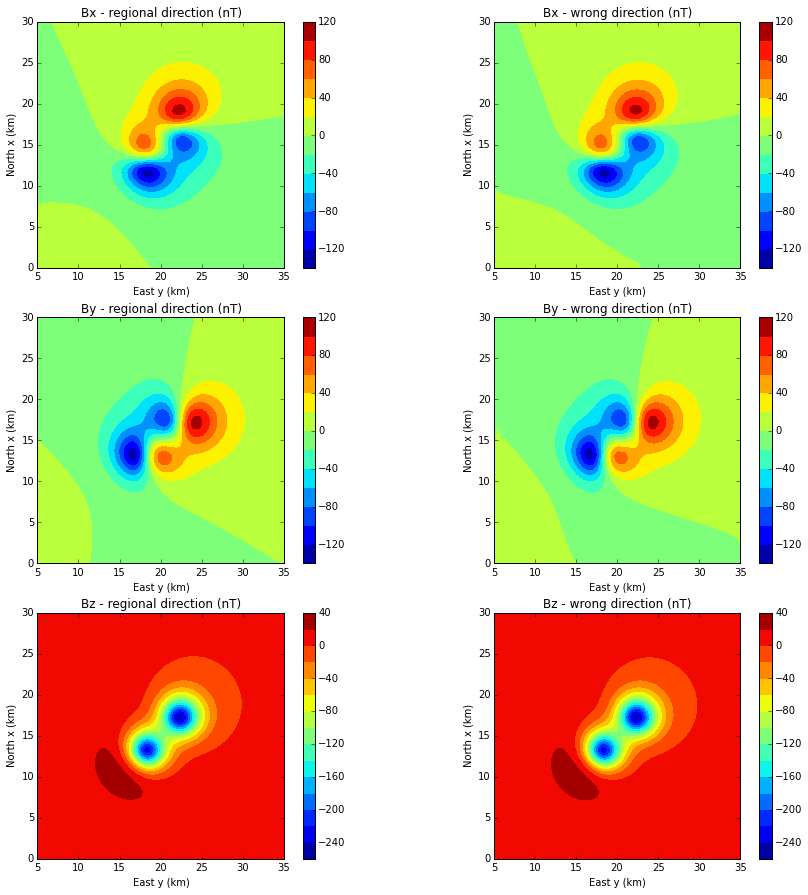

In [38]:
mpl.figure(figsize=(15,15))
mpl.axis('scaled')

mpl.subplot(3,2,1)
mpl.axis('scaled')
mpl.title("Bx - regional direction (nT)")
mpl.contourf(yp, xp, Bx,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,2)
mpl.axis('scaled')
mpl.title("Bx - wrong direction (nT)")
mpl.contourf(yp, xp, Bx_layer_fd,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,3)
mpl.axis('scaled')
mpl.title("By - regional direction (nT)")
mpl.contourf(yp, xp, By,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,4)
mpl.axis('scaled')
mpl.title("By - wrong direction (nT)")
mpl.contourf(yp, xp, By_layer_fd,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,5)
mpl.axis('scaled')
mpl.title("Bz - regional direction (nT)")
mpl.contourf(yp, xp, Bz,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.subplot(3,2,6)
mpl.axis('scaled')
mpl.title("Bz - wrong direction (nT)")
mpl.contourf(yp, xp, Bz_layer_fd,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar()
mpl.m2km()

mpl.show()

In [39]:
A_btb = mfun.sm_btb_sphere(xp, yp, zp, xp, yp, h, inc, dec)

In [40]:
btb = np.sqrt(np.dot(A_btb,vp**2))

In [41]:
#btb_layer = np.sqrt(Bx_layer**2 + By_layer**2 + Bz_layer**2)

In [42]:

A_btbw = mfun.sm_btb_sphere(xp, yp, zp, xp, yp, h, incs, decs)

In [43]:
BTB_true = np.sqrt(Bx**2 + By**2 + Bz**2)

In [44]:
BTB_layer_fd = np.sqrt(Bx_layer_fd**2 + By_layer_fd**2 + Bz_layer_fd**2)

In [45]:
btbw = np.sqrt(np.dot(A_btbw,vp**2))

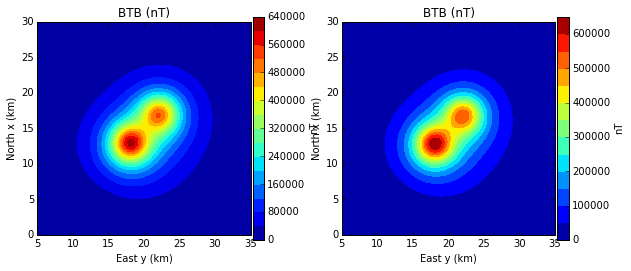

In [46]:
mpl.figure(figsize=(10,10))
mpl.subplot(1,2,1)
mpl.title("BTB (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, btb,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.subplot(1,2,2)
mpl.title("BTB (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, btbw,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.show()

In [47]:
btb_fat = np.sqrt(sphere.bx(xp,yp,zp,model_fat)**2 + \
                  sphere.by(xp,yp,zp,model_fat)**2 + \
                  sphere.bz(xp,yp,zp,model_fat)**2)

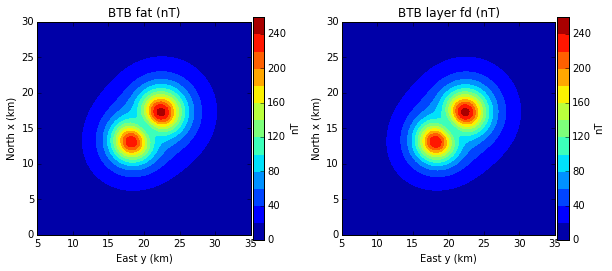

In [48]:
mpl.figure(figsize=(10,10))
mpl.subplot(1,2,1)
mpl.title("BTB fat (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, BTB_true,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.subplot(1,2,2)
mpl.title("BTB layer fd (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, BTB_layer_fd,shape, 15)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.show()

In [49]:
btb_layer.shape

NameError: name 'btb_layer' is not defined